In [1]:
#install.packages("ranger")

library(ranger)
library(dplyr)
library(rsample)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: broom
Loading required package: tidyr

Attaching package: 'rsample'

The following object is masked from 'package:tidyr':

    fill



In [2]:
df_data <- read.csv("../data/cust_churn.csv", fileEncoding = "UTF-8-BOM", stringsAsFactors = F) %>% na.omit() %>% select(-customerID) %>% mutate(Churn = as.numeric(Churn == "Yes"))

In [3]:
split_set <- initial_split(df_data, prop = 0.75)

In [4]:
df_train <- training(split_set)
df_test <- testing(split_set)

In [5]:
base_model <- ranger(
    formula = Churn ~ .,
    data = df_train,
    importance = "impurity"
)

In [6]:
base_model

Ranger result

Call:
 ranger(formula = Churn ~ ., data = df_train, importance = "impurity") 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      5274 
Number of independent variables:  19 
Mtry:                             4 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.1418916 
R squared (OOB):                  0.2815163 

In [21]:
library(InformationValue)
library(yardstick)

In [22]:
vec_pred_y <- predict(base_model, df_test %>% select(-Churn))[["predictions"]]
vec_test_y <- df_test$Churn %>% as.vector()

In [23]:
#opt_cut <- optimalCutoff(vec_test_y, vec_pred_y)
vec_est_y <- ifelse(vec_pred_y <= 0.5, 0, 1)

In [24]:
library(forcats)
options(yardstick.event_first = FALSE)
tbl_estimates <- tibble(
    truth      = as.factor(vec_test_y) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(vec_est_y) %>% fct_recode(yes = "1", no = "0"),
    class_prob = vec_pred_y
)

head(tbl_estimates)

truth,estimate,class_prob
no,no,0.02949641
no,no,0.46661622
no,no,0.03671632
no,no,0.07969611
no,no,0.03830390
yes,no,0.40646560


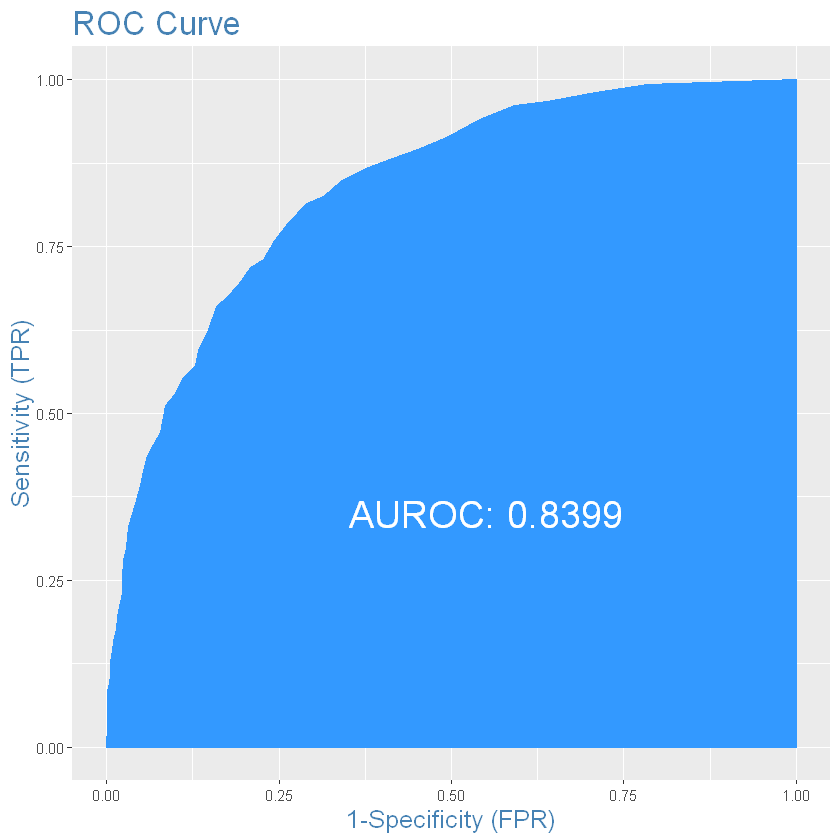

In [25]:
plotROC(actuals = vec_test_y, predictedScores = vec_pred_y)

In [14]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_est_y)

ERROR: Error in ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_est_y): could not find function "ks_plot"


In [15]:
optimalCutoff(vec_test_y, vec_pred_y)

ERROR: Error in optimalCutoff(vec_test_y, vec_pred_y): could not find function "optimalCutoff"


In [16]:
tbl_estimates %>% conf_mat(truth, estimate)

          Truth
Prediction   no  yes
       no  1204  215
       yes  113  226

In [17]:
# Accuracy
tbl_estimates %>% metrics(truth, estimate)

accuracy
0.8134243


In [18]:
# Precision
tibble(
    precision = tbl_estimates %>% precision(truth, estimate),
    recall    = tbl_estimates %>% recall(truth, estimate)
)

precision,recall
0.6666667,0.5124717


In [ ]:
base_model$variable.importance %>% 
  tidy() %>%
  arrange(desc(x)) %>%
  top_n(25) %>%
  ggplot(aes(reorder(names, x), x)) +
  geom_col() +
  coord_flip() +
  ggtitle("Top 25 important variables")

# Use standardised dataset to se if it improves the fit.

In [ ]:
df_train_x <- read.csv("../data/df_train_x.csv") %>% select(-X)
df_test_x <- read.csv("../data/df_test_x.csv") %>% select(-X)
vec_train_y <- read.csv("../data/vec_train_y.csv") %>% select(-X)
vec_test_y <- read.csv("../data/vec_test_y.csv") %>% select(-X)
df_train <- cbind(df_train_x, churn=vec_train_y) %>% select(churn = x, everything())
df_test <- cbind(df_test_x, churn=vec_test_y) %>% select(churn = x, everything())

In [ ]:
std_model <- ranger(
    formula = churn ~ .,
    data = df_train,
    num.trees = 500,
    importance = "impurity"
)

In [ ]:
vec_pred_y <- predict(std_model, df_test %>% select(-churn))[["predictions"]]
vec_test_y <- df_test$churn %>% as.vector()

In [ ]:
opt_cut <- optimalCutoff(vec_test_y, vec_pred_y)
vec_est_y <- ifelse(vec_pred_y <= opt_cut, 0, 1)

In [ ]:
library(forcats)
options(yardstick.event_first = FALSE)
tbl_estimates <- tibble(
    truth      = as.factor(vec_test_y) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(vec_est_y) %>% fct_recode(yes = "1", no = "0"),
    class_prob = vec_pred_y
)

head(tbl_estimates)

In [ ]:
plotROC(actuals = vec_test_y, predictedScores = vec_pred_y)

In [ ]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_est_y)

In [ ]:
optimalCutoff(vec_test_y, vec_pred_y)

In [ ]:
tbl_estimates %>% conf_mat(truth, estimate)

In [ ]:
# Accuracy
tbl_estimates %>% metrics(truth, estimate)

In [ ]:
# Precision
tibble(
    precision = tbl_estimates %>% precision(truth, estimate),
    recall    = tbl_estimates %>% recall(truth, estimate)
)

# Tune model hyperparameters

In [ ]:
library(rBayesianOptimization)

In [ ]:
hyper_grid <- expand.grid(
  mtry       = seq(20, 30, by = 2),
  node_size  = seq(3, 9, by = 2),
  sampe_size = c(.55, .632, .70, .80),
  OOB_RMSE   = 0
)

# total number of combinations
nrow(hyper_grid)
## [1] 96

In [ ]:
for(i in 1:nrow(hyper_grid)) {
  
  # train model
  model <- ranger(
    formula         = churn ~ ., 
    data            = df_train, 
    num.trees       = 500,
    mtry            = hyper_grid$mtry[i],
    min.node.size   = hyper_grid$node_size[i],
    sample.fraction = hyper_grid$sampe_size[i],
    seed            = 123
  )
  
  # add OOB error to grid
  hyper_grid$OOB_RMSE[i] <- sqrt(model$prediction.error)
}

In [ ]:
hyper_grid %>% 
  dplyr::arrange(OOB_RMSE) %>%
  head(10)

In [ ]:
opt_model <- ranger(
    formula = churn ~ .,
    data = df_train,
    num.trees = 1000,
    mtry = 20,
    min.node.size = 9,
    sample.fraction = 0.55,
    importance = "impurity"
)

In [ ]:
vec_pred_y <- predict(opt_model, df_test %>% select(-churn))[["predictions"]]
vec_test_y <- df_test$churn %>% as.vector()

In [ ]:
opt_cut <- optimalCutoff(vec_test_y, vec_pred_y)
vec_est_y <- ifelse(vec_pred_y <= opt_cut, 0, 1)

In [ ]:
library(forcats)
options(yardstick.event_first = FALSE)
tbl_estimates <- tibble(
    truth      = as.factor(vec_test_y) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(vec_est_y) %>% fct_recode(yes = "1", no = "0"),
    class_prob = vec_pred_y
)

head(tbl_estimates)

In [ ]:
plotROC(actuals = vec_test_y, predictedScores = vec_pred_y)

In [ ]:
ks_plot(actuals = as.numeric(vec_test_y), predictedScores = vec_est_y)

In [ ]:
optimalCutoff(vec_test_y, vec_pred_y)

In [ ]:
tbl_estimates %>% conf_mat(truth, estimate)

In [ ]:
# Accuracy
tbl_estimates %>% metrics(truth, estimate)

In [ ]:
# Precision
tibble(
    precision = tbl_estimates %>% precision(truth, estimate),
    recall    = tbl_estimates %>% recall(truth, estimate)
)

In [ ]:
opt_model$variable.importance %>% 
  tidy() %>%
  arrange(desc(x)) %>%
  top_n(25) %>%
  ggplot(aes(reorder(names, x), x)) +
  geom_col() +
  coord_flip() +
  ggtitle("Top 25 important variables")